# Purpose

This notebook models and forecasts realised volatility using exponential smoothing methods, and evaluates out-of-sample performance against a naive benchmark.

Exponential smoothing is used as a simple benchmark for modelling persistent volatility dynamics without imposing a parametric structure.

# Load libraries and data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

vol = vol_df["realised_vol_21d"]

# Train / test split

In [3]:
split_date = "2022-01-01"

train = vol.loc[vol.index < split_date]
test  = vol.loc[vol.index >= split_date]

Training: 2010–2021

Test: 2022–2024

# Baseline volatility model (naive)

In [4]:
naive_forecast = vol.shift(1).loc[test.index]
naive_forecast = naive_forecast.dropna()
test_naive = test.loc[naive_forecast.index]

In [5]:
naive_mae = mean_absolute_error(test_naive, naive_forecast)
naive_rmse = root_mean_squared_error(test_naive, naive_forecast)

naive_mae, naive_rmse

(0.0003513788499757026, 0.0005920199226435071)

# ETS model specification

Volatility has:

* Level, as volatility regimes shift abruptly

* No trend worth trusting, as trends are unstable

* No seasonality worth forcing, as calendar seasonality is weak at daily horizons

In [6]:
ets_model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal=None
)

ets_fit = ets_model.fit()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
ets_fit.params

{'smoothing_level': np.float64(0.9956126936458926),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(0.009563621375942957),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Since smoothing_level is $\approx 1$, it statistically proves that the best way to forecast tomorrow's 21-day volatility is simply to use today's value.

# Out-of-sample forecasting

In [7]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)

    history = train.copy()
    ets_forecasts = []

    for t in range(len(test)):
        model = ExponentialSmoothing(
            history,
            trend=None,
            seasonal=None
        )
        fit = model.fit()
        forecast = fit.forecast(steps=1)
        ets_forecasts.append(forecast.iloc[0])
        history = pd.concat([history, test.iloc[t:t+1]])

An expanding-window approach is used to mirror real-time forecasting, although ETS forecasts are dominated by the most recent observation.

In [8]:
ets_forecasts = pd.Series(
    ets_forecasts,
    index=test.index
)

# Forecast residual diagnostics

In [9]:
residuals = test - ets_forecasts

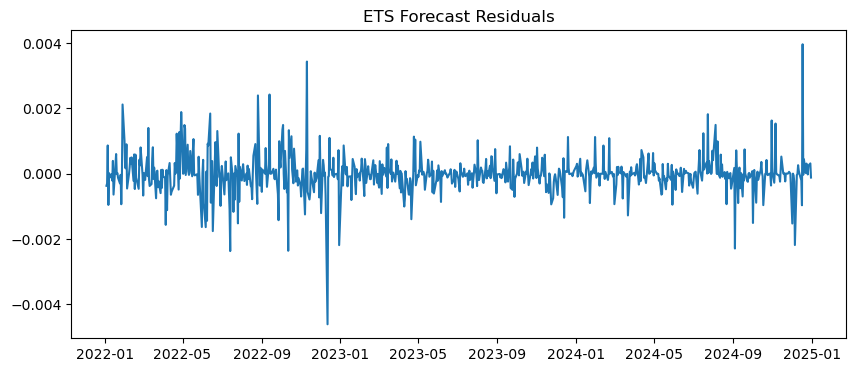

In [10]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ETS Forecast Residuals")
plt.show()

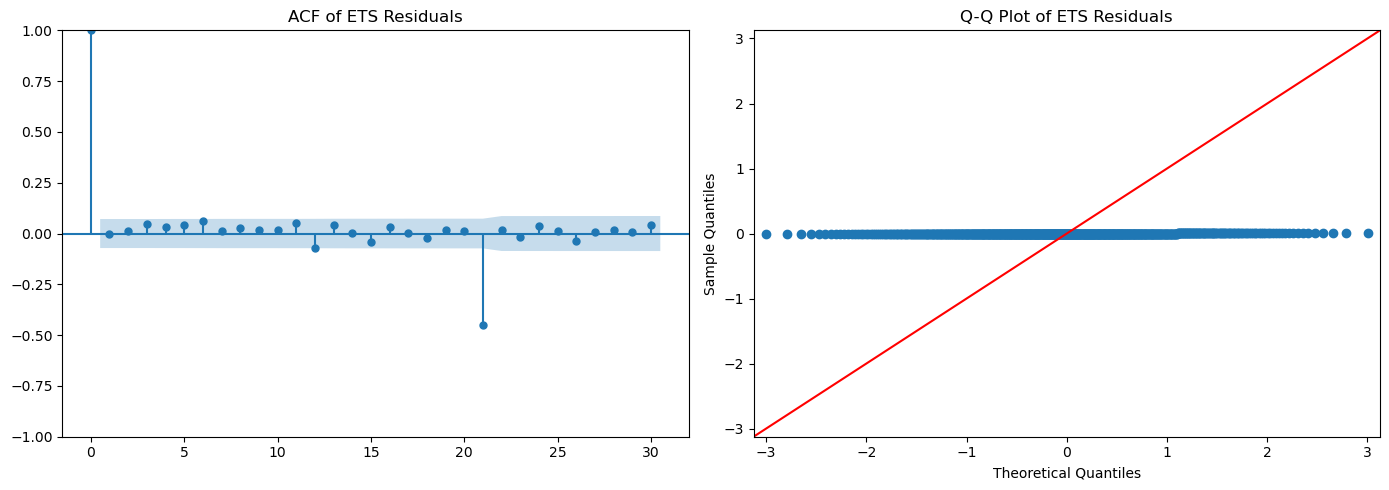

Ljung-Box test on Squared Residuals (p-value):
0.7768629440200197


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title("ACF of ETS Residuals")

sm.qqplot(residuals, line='45', ax=ax[1])
ax[1].set_title("Q-Q Plot of ETS Residuals")

plt.tight_layout()
plt.show()

In [26]:
lb_res = acorr_ljungbox(residuals**2, lags=[10], return_df=True)
print("Ljung-Box test on Squared Residuals (p-value):")
print(lb_res['lb_pvalue'].iloc[0])

Ljung-Box test on Squared Residuals (p-value):
0.7768629440200197


The high p-value for squared residuals indicates that the errors appear as white noise.

The significant negative spike at lag 21 is a mathematical artifact of the 21-day rolling window. An outlier in the returns enters the window on day 1 and exits on day 21, creating a mechanical correlation.

The Q-Q plot shows a severe "flat" horizontal pattern. This confirms that the residuals do not follow a normal distribution. The ETS model is struggling to map the error distribution correctly because it is forecasting a smoothed, lagging proxy (21-day RV) rather than the raw innovation of the market.

# Model evaluation

In [11]:
ets_mae = mean_absolute_error(test, ets_forecasts)
ets_rmse = root_mean_squared_error(test, ets_forecasts)

pd.DataFrame({
    "Model": ["Naive Volatility", "ETS"],
    "MAE": [naive_mae, ets_mae],
    "RMSE": [naive_rmse, ets_rmse]
})

,Model,MAE,RMSE
0,Naive Volatility,0.000351,0.000592
1,ETS,0.000351,0.000592


# Forecast visualisation

In [12]:
# Convert list of forecasts to pandas Series with correct index
ets_forecasts = pd.Series(ets_forecasts, index=test.index)

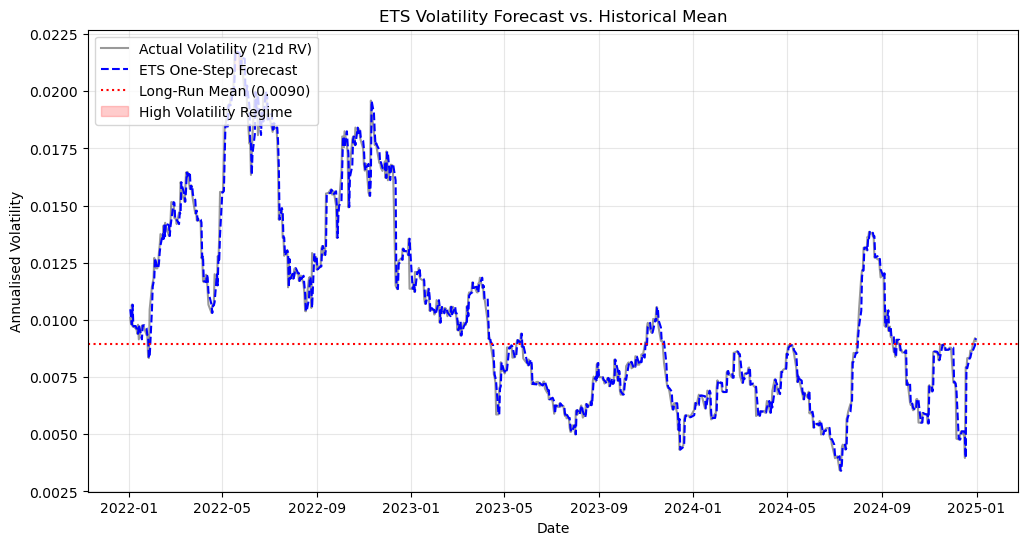

In [25]:
# Calculate Long-Run Mean from training data
long_run_mean = train.mean()

plt.figure(figsize=(12, 6))

# Plot actuals and forecasts
plt.plot(test.index, test, label="Actual Volatility (21d RV)", color='black', alpha=0.4)
plt.plot(test.index, ets_forecasts, label="ETS One-Step Forecast", color='blue', linestyle='--')

# Plot Long-Run Mean
plt.axhline(y=long_run_mean, color='red', linestyle=':', label=f"Long-Run Mean ({long_run_mean:.4f})")

# Highlight Regime Shifts (Example: High Volatility Periods)
high_vol_threshold = long_run_mean + (2 * train.std())
plt.fill_between(test.index, test, high_vol_threshold, 
                 where=(test > high_vol_threshold), color='red', alpha=0.2, label="High Volatility Regime")

plt.title("ETS Volatility Forecast vs. Historical Mean")
plt.xlabel("Date")
plt.ylabel("Annualised Volatility")
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

Smooth tracking

Much smaller errors than returns

Volatility is theoretically mean-reverting in 2022

Missing High Volatility Regime

# Interpretation

At a one-step-ahead horizon, realised volatility is highly persistent, resulting in similar performance between naive and ETS forecasts. 

This highlights the strong memory inherent in volatility processes.

At short horizons, simple persistence-based forecasts are difficult to outperform.

Remaining signal cannot be extracted from the rolling series itself, necessitating the direct modelling of daily returns via GARCH.

# Save forecasts

In [14]:
ets_forecasts.to_csv("../outputs/forecasts/ets_volatility_forecast.csv")